# Data Preprocessing

In [ ]:
#Importing packages for necessary purposes

import numpy as np
import keras 
import pandas as pd
import tensorflow as tf
import re
import nltk

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from keras.regularizers import l2


In [ ]:
#Importing data
imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data.isnull().values.any()
print (imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#Looking at the reviews
imdb_data["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
#cleaning reviews
def review_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(imdb_data['review'])
for sen in sentences:
    X.append(review_text(sen))

In [ ]:
X[1]

'A wonderful little production The filming technique is very unassuming very old time BBC fashion and gives comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is terrificly written and performed piece masterful production about one of the great master of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwell murals decorating every surface are terribly well done '

In [ ]:
#converting positive to 1 and negative to 0
Y = imdb_data['sentiment']

Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [ ]:
seed=42
np.random.seed(seed)

In [ ]:
#shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X_temp, Y_train = np.array(X)[idx], Y[idx]
X_train = []
for sen in X_temp:
    X_train.append(sen)

In [ ]:
#splitting the data into 70:30 train:test
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(len(X_train))
print(len(X_test))

35000
15000


In [ ]:
#Tokenization of text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#X_train

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

#cutoff word length per review
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#X_test

In [ ]:
vocab_size

87633

In [ ]:
#dictionary
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
#embeddings_dictionary

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#embedding_matrix

# Training with a simple neural network

In [ ]:
#define params for model
NUM_CLASSES = 1 #positive or negative

epochs = 100

lr = 0.001 #learning rate
beta = 1e-9 #weight decay param
batch_size = 128
hidden_neurons = 10

In [ ]:
#create starting model
def create_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights = [embedding_matrix], 
                                input_length = maxlen, trainable = False)
    model.add(embedding_layer)
    #flatten embedded layers output to to 1 dimension
    model.add(Flatten())
    
    #one hidden layer with 10 hidden neurons, relu activation, l2 regulariation
    #output layer with 1 neuron, sigmoid activation, l2 regularisation
    model.add(Dense(hidden_neurons, activation = 'relu', kernel_regularizer=l2(beta)))
    model.add(Dense(NUM_CLASSES, activation = 'sigmoid', kernel_regularizer=l2(beta)))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer = optimizer,
                 loss = 'binary_crossentropy',
                 metrics=['accuracy'])
   
    return model

In [ ]:
#train model
model = create_model()
history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    verbose = 2,
                    batch_size = batch_size,
                    validation_data = (X_test, Y_test)
                   )

Epoch 1/100
274/274 - 2s - loss: 0.6941 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 2/100
274/274 - 2s - loss: 0.6906 - accuracy: 0.5147 - val_loss: 0.6558 - val_accuracy: 0.6176
Epoch 3/100
274/274 - 2s - loss: 0.6084 - accuracy: 0.6979 - val_loss: 0.5878 - val_accuracy: 0.7221
Epoch 4/100
274/274 - 2s - loss: 0.5308 - accuracy: 0.7635 - val_loss: 0.5665 - val_accuracy: 0.7349
Epoch 5/100
274/274 - 2s - loss: 0.4878 - accuracy: 0.7915 - val_loss: 0.5484 - val_accuracy: 0.7355
Epoch 6/100
274/274 - 2s - loss: 0.4600 - accuracy: 0.8044 - val_loss: 0.5469 - val_accuracy: 0.7432
Epoch 7/100
274/274 - 2s - loss: 0.4374 - accuracy: 0.8177 - val_loss: 0.5486 - val_accuracy: 0.7417
Epoch 8/100
274/274 - 2s - loss: 0.4235 - accuracy: 0.8225 - val_loss: 0.5510 - val_accuracy: 0.7382
Epoch 9/100
274/274 - 2s - loss: 0.4088 - accuracy: 0.8316 - val_loss: 0.5601 - val_accuracy: 0.7413
Epoch 10/100
274/274 - 2s - loss: 0.3982 - accuracy: 0.8364 - val_loss: 0.5707 - val_accura

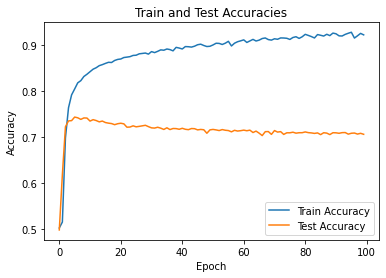

In [ ]:
#Summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

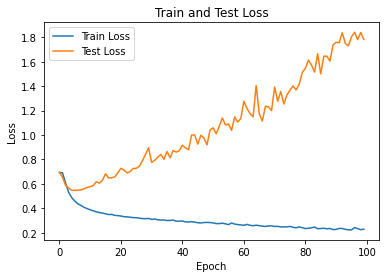

In [ ]:
#Summarize history for loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Reduce overfitting by introducing dropouts

In [ ]:
#define params for model
NUM_CLASSES = 1 #positive or negative

epochs = 100

lr = 0.001 #learning rate
beta = 1e-9 #weight decay param
batch_size = 128
hidden_neurons = 10

In [ ]:
#create model with dropouts
def create_model_dropout():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights = [embedding_matrix], 
                                input_length = maxlen, trainable = False)
    model.add(embedding_layer)
    #flatten embedded layers output to to 1 dimension
    model.add(Flatten())
    
    #add dropout 0.5 probability
    model.add(Dropout(0.5))
    #one hidden layer with 10 hidden neurons, relu activation, l2 regulariation
    #output layer with 1 neuron, sigmoid activation, l2 regularisation
    model.add(Dense(hidden_neurons, activation = 'relu', kernel_regularizer=l2(beta)))
    model.add(Dense(NUM_CLASSES, activation = 'sigmoid', kernel_regularizer=l2(beta)))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer = optimizer,
                 loss = 'binary_crossentropy',
                 metrics=['accuracy'])
   
    return model

In [ ]:
#train model
model = create_model_dropout()
history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    verbose = 2,
                    batch_size = batch_size,
                    validation_data = (X_test, Y_test)
                   )

Epoch 1/100
274/274 - 2s - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/100
274/274 - 2s - loss: 0.6931 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 3/100
274/274 - 2s - loss: 0.6905 - accuracy: 0.5190 - val_loss: 0.6674 - val_accuracy: 0.6021
Epoch 4/100
274/274 - 2s - loss: 0.6480 - accuracy: 0.6376 - val_loss: 0.6251 - val_accuracy: 0.6691
Epoch 5/100
274/274 - 2s - loss: 0.6014 - accuracy: 0.6901 - val_loss: 0.5796 - val_accuracy: 0.7170
Epoch 6/100
274/274 - 2s - loss: 0.5742 - accuracy: 0.7115 - val_loss: 0.5648 - val_accuracy: 0.7305
Epoch 7/100
274/274 - 2s - loss: 0.5576 - accuracy: 0.7244 - val_loss: 0.5573 - val_accuracy: 0.7285
Epoch 8/100
274/274 - 2s - loss: 0.5434 - accuracy: 0.7338 - val_loss: 0.5426 - val_accuracy: 0.7390
Epoch 9/100
274/274 - 2s - loss: 0.5382 - accuracy: 0.7353 - val_loss: 0.5351 - val_accuracy: 0.7403
Epoch 10/100
274/274 - 2s - loss: 0.5320 - accuracy: 0.7383 - val_loss: 0.5351 - val_accura

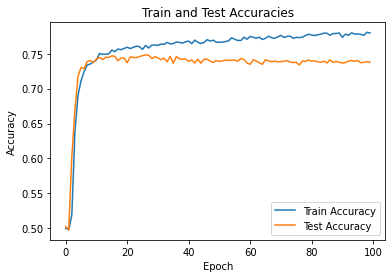

In [ ]:
#Summarize history for accuracy (with dropout)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

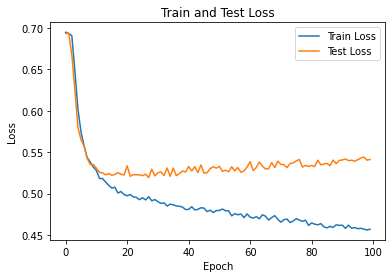

In [ ]:
#Summarize history for loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()